In [1]:
import os
import time
import scipy.io as sio
import numpy as np

from my_funcs.plot_functions import t1_t2_pixel_reader

from my_funcs.cest_functions import bruker_dataset_creator
from my_funcs.cest_functions import dicom_data_arranger

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable


In [3]:
# Use GPU if available (otherwise use CPU)
if torch.cuda.is_available():
    device = 'cuda'
    print('GPU found and will be used')
else:
    device = 'cpu'
    'GPU was not found. Using CPU'

sched_iter = 31
dtype = torch.DoubleTensor


NameError: name 'torch' is not defined

## scan data ##

In [53]:
# Root stats:
general_fn = os.path.abspath(os.curdir)
current_dir = os.getcwd()  # Get the current directory
parent_dir = os.path.dirname(current_dir)  # Navigate up one directory level

dict_name = 'mouse_pickle'  # 'mouse_40', 'mouse_pickle', 'mouse_t_range', 'mouse_k_8500', 'mouse_larger_k', 'mouse_t_range_20'
net_name = 'mouse_20_noise_0'  # ['mouse_40_noise_01', 'mouse_40_noise_005', 'mouse_40_noise_001'], ['mouse_20_noise_01', 'mouse_20_noise_005'], ['mouse_t_range_noise_01'], ['mouse_k_8500_noise_01'], ['mouse_larger_k_noise_01'], ['mouse_20_noise_01']
glu_noise = '0'

# Dict choice:
mt_dict_fn = os.path.join(parent_dir, 'data', 'exp', 'MT_pickle', 'MT52', 'dict.pkl') 
glu_dict_fn = os.path.join(parent_dir, 'data', 'exp', dict_name, '107a', 'dict.pkl')

# NN choice:
mt_nn_fn = os.path.join(current_dir, 'mouse_nns', 'mt_nns', f'mt_noise_01.pt') # mt nn directory
glu_nn_fn = os.path.join(current_dir, 'mouse_nns', 'glu_nns', f'{dict_name}', f'{net_name}.pt')  # nn directory # 'checkpoint_107a.pt'


# Subject data:
txt_file_name = 'labarchive_notes.txt'
save_name = 'mouse_mt_107'
fp_prtcl_names = ['107a']  # to be looped later with all options # 107a , 51_glu
f_const = 3 / 110000

subject_dicts = [
    {'scan_name': '24_04_04_glu_tumor_mouse_37deg',
     'sub_name': '1_mouse1_left',
     'month': 'apr',
     'save_name': save_name,
     'center': [39, 15],
     'voxel_origin': [28, 13],
     't_shift': [1, 8],  # up, right 
     'temp': 37,
     'z_b1s': [0.7, 1.5],
     'z_b1s_names': ['0p7uT', '1p5uT']
     },
    {'scan_name': '24_04_04_glu_tumor_mouse_37deg',
     'sub_name': '2_mouse2_right',
     'month': 'apr',
     'center': [25, 14],
     'voxel_origin': [16, 11],
     't_shift': [0, 0],  # up, right 
     'save_name': save_name,
     'temp': 37,
     'z_b1s': [0.7, 1.5],
     'z_b1s_names': ['0p7uT', '1p5uT']
     },
        {'scan_name': '24_04_04_glu_tumor_mouse_37deg',
     'sub_name': '3_mouse3_two_ears',
     'month': 'apr',
     'center': [30, 19],
     'voxel_origin': [21, 14],
     't_shift': [0, 0],  # up, right 
     'save_name': save_name,
     'temp': 37,
     'z_b1s': [0.7, 1.5],
     'z_b1s_names': ['0p7uT', '1p5uT']
     },
     #    {'scan_name': '24_01_28_glu_mouse_37deg',
     # 'sub_name': '1_or_dino_mouse2_right_ear_middle_pierce',
     # 'month': 'jan',
     # 'center': [0, 0],
     # 'voxel_origin': [0, 0],
     # 'save_name': save_name,
     # 'temp': 37,
     # 'z_b1s': [0.7, 2],
     # 'z_b1s_names': ['0p7uT', '2uT']
     # },
 ]

subject_dicts = [
        {'scan_name': '24_06_03_glu_mouse_37deg',
     'sub_name': '1_mouse_old_tail_broken',
     'month': 'june',
     'save_name': save_name,
     'center': [39, 15],
     'voxel_origin': [28, 13],
     't_shift': [0, 0],  # up, right
     'highres_img_idx': 0,
     'resratio': 2,
     'temp': 37,
     'z_b1s': [0.7, 1.5],
     'z_b1s_names': ['0p7uT', '1p5uT']
     },
        {'scan_name': '24_06_03_glu_mouse_37deg',
     'sub_name': '2_mouse_old_female_3bends',
     'month': 'june',
     'save_name': save_name,
     'center': [39, 15],
     'voxel_origin': [28, 13],
     't_shift': [0, 0],  # up, right
     'highres_img_idx': 1,
     'resratio': 2,
     'temp': 37,
     'z_b1s': [0.7, 1.5],
     'z_b1s_names': ['0p7uT', '1p5uT']
     },
        {'scan_name': '24_06_03_glu_mouse_37deg',
     'sub_name': '3_mouse_old_male_2bends',
     'month': 'june',
     'save_name': save_name,
     'center': [39, 15],
     'voxel_origin': [28, 13],
     't_shift': [0, 0],  # up, right
     'highres_img_idx': 1,
     'resratio': 2,
     'temp': 37,
     'z_b1s': [0.7, 1.5],
     'z_b1s_names': ['0p7uT', '1p5uT']
     },
        {'scan_name': '24_06_03_glu_mouse_37deg',
     'sub_name': '4_mouse_old_male_1band',
     'month': 'june',
     'save_name': save_name,
     'center': [39, 15],
     'voxel_origin': [28, 13],
     't_shift': [-1, 0],  # up, right
     'highres_img_idx': 0,
     'resratio': 2,
     'temp': 37,
     'z_b1s': [0.7, 1.5],
     'z_b1s_names': ['0p7uT', '1p5uT']
     },
 ]


## choose scan ##

In [54]:
fp_prtcl_name = fp_prtcl_names[0]
subject_i = 2

subject_dict = subject_dicts[subject_i]
phantom_choice = subject_i+1
glu_mouse_fn = os.path.join(parent_dir, 'data', 'scans', subject_dict['scan_name'], subject_dict['sub_name'])

glu_107a_fn, glu_mouse_mrf_files_fn, bruker_dataset_107a = bruker_dataset_creator(glu_mouse_fn, txt_file_name, '107a')
mt_25_fn, _, bruker_dataset_52 = bruker_dataset_creator(glu_mouse_fn, txt_file_name, 'MT52')


## mask ##

In [55]:
# mask_path = os.path.join(os.path.dirname(os.path.dirname(glu_mouse_mrf_files_fn)), 'mask.npy')
mask_path = os.path.join(os.path.dirname(os.path.dirname(glu_mouse_mrf_files_fn)), 'ds_mask.npy')
mask = np.load(mask_path)
subject_dict['roi_mask'] = mask


In [56]:
highres_fn, _, bruker_dataset_highres = bruker_dataset_creator(glu_mouse_fn, txt_file_name, 'T2_MSME_high')


## Data preparation ##

In [57]:
# Loading the acquired data
acquired_data_52 = dicom_data_arranger(bruker_dataset_52, mt_25_fn).astype(np.float)
[_, c_acq_data, w_acq_data] = np.shape(acquired_data_52*mask)  # mask here

# Reshaping the acquired data to the shape expected by the NN (e.g. 31 x ... )
acquired_data_52 = np.reshape(acquired_data_52, (sched_iter, c_acq_data * w_acq_data), order='F')

# 2-norm normalization of the dictionary signals
acquired_data_52 = acquired_data_52 / np.sqrt(np.sum(acquired_data_52 ** 2, axis=0))

# Transposing for compatibility with the NN - now each row is a trajectory
acquired_data_52 = acquired_data_52.T

# Converting to tensor
acquired_data_52 = Variable(torch.from_numpy(acquired_data_52).type(dtype), requires_grad=False).to(device)
    

In [58]:
# Loading the acquired data
acquired_data_107a = dicom_data_arranger(bruker_dataset_107a, glu_107a_fn).astype(np.float)
[_, c_acq_data, w_acq_data] = np.shape(acquired_data_107a*mask)  # mask here

# Reshaping the acquired data to the shape expected by the NN (e.g. 31 x ... )
acquired_data_107a = np.reshape(acquired_data_107a, (sched_iter, c_acq_data * w_acq_data), order='F')

# 2-norm normalization of the dictionary signals
acquired_data_107a = acquired_data_107a / np.sqrt(np.sum(acquired_data_107a ** 2, axis=0))

# Transposing for compatibility with the NN - now each row is a trajectory
acquired_data_107a = acquired_data_107a.T

# Converting to tensor
acquired_data_107 = Variable(torch.from_numpy(acquired_data_107a).type(dtype), requires_grad=False).to(device)


In [59]:
# Loading the separately acquired water_t1t2-maps
t1 = t1_t2_pixel_reader(glu_phantom_fn=glu_mouse_fn, txt_file_name=txt_file_name, image_idx=3, t_type='t1',
                               image_file=4)
t2 = t1_t2_pixel_reader(glu_phantom_fn=glu_mouse_fn, txt_file_name=txt_file_name, image_idx=3, t_type='t2')

shift_up, shift_right = subject_dict['t_shift']
t1 = np.roll(t1, shift=(shift_up, shift_right), axis=(0, 1))
t2 = np.roll(t2, shift=(shift_up, shift_right), axis=(0, 1))

masked_t1 = np.ma.masked_where(mask == 0, t1)
masked_t2 = np.ma.masked_where(mask == 0, t2)

print(f't1 min-max: [{np.min(masked_t1), np.max(masked_t1)}]')
print(f't2 min-max: [{np.min(masked_t2), np.max(masked_t2)}]')


t1 min-max: [(1065.3005492415, 2567.3430831867)]
t2 min-max: [(38.034619465359995, 299.19398814455997)]


In [60]:
# Reshaping the acquired data to the shape expected by the NN (e.g. 2 x ... )
acquired_map_t1w_orig = t1.astype(np.float32) / 1000
acquired_map_t2w_orig = t2.astype(np.float32) / 1000

acquired_map_t1w = np.reshape(acquired_map_t1w_orig, (1, c_acq_data * w_acq_data), order='F').T
acquired_map_t1w = torch.from_numpy(acquired_map_t1w)

acquired_map_t2w = np.reshape(acquired_map_t2w_orig, (1, c_acq_data * w_acq_data), order='F').T
acquired_map_t2w = torch.from_numpy(acquired_map_t2w)


## 1. MT step ##

In [61]:
from mt_nn import Network
from mt_nn import define_min_max

# mt_dict_fn = os.path.join(parent_dir, 'data', 'exp', 'MT_pickle', 'MT52', 'dict.pkl') 
# "D:\mrf\data\exp\MT_pickle\MT52\dict.pkl"
min_param_tensor, max_param_tensor, min_water_t1t2_tensor, max_water_t1t2_tensor = define_min_max(mt_dict_fn)


### 1.a. load model ###

In [62]:
reco_net = Network(sched_iter).to(device)
checkpoint = torch.load(mt_nn_fn)
reco_net.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

## 1.b. MT maps (protocol mt52) ##

In [63]:
from mt_nn import normalize_range

# Normalizing according to dict water_t1t2 min and max values
input_water_t1t2_acquired = torch.hstack((acquired_map_t1w, acquired_map_t2w))
input_water_t1t2_acquired = normalize_range(original_array=input_water_t1t2_acquired,
                                            original_min=min_water_t1t2_tensor,
                                            original_max=max_water_t1t2_tensor, new_min=0, new_max=1).to(device)

# adding the water_t1t2 input as two additional elements in the noised_sig vector
acquired_data = torch.hstack((input_water_t1t2_acquired, acquired_data_52)).to(device).float()


## 1.c. evaluate ##

In [64]:
from mt_nn import un_normalize_range

reco_net.eval()
t0 = time.time()
prediction = reco_net(acquired_data.float())
print(f"Prediction took {time.time() - t0:.5f} seconds")

# Un-normalizing to go back to physical units
prediction = un_normalize_range(prediction, original_min=min_param_tensor.to(device),
                                original_max=max_param_tensor.to(device), new_min=0, new_max=1)

# print(prediction.shape)

# mask = np.ones((c_acq_data, w_acq_data))
quant_maps_mt = {}

# Reshaping back to the image dimension
quant_maps_mt['fs'] = prediction.cpu().detach().numpy()[:, 0]
quant_maps_mt['fs'] = quant_maps_mt['fs'].T
quant_maps_mt['fs'] = np.reshape(quant_maps_mt['fs'], (c_acq_data, w_acq_data), order='F')

quant_maps_mt['ksw'] = prediction.cpu().detach().numpy()[:, 1]
quant_maps_mt['ksw'] = quant_maps_mt['ksw'].T
quant_maps_mt['ksw'] = np.reshape(quant_maps_mt['ksw'], (c_acq_data, w_acq_data), order='F')

input_mt_param = prediction.cpu().detach().numpy()
input_mt_param = torch.from_numpy(input_mt_param)


Prediction took 0.00100 seconds


## 2. Glu step ##

In [65]:
from glu_nn import MNetwork
from glu_nn import normalize_range, un_normalize_range, define_min_max

# glu_dict_fn = f"D:\mrf\data\exp\mouse_pickle\{107}a\dict.pkl"
(min_param_tensor, max_param_tensor, min_water_t1t2_tensor, max_water_t1t2_tensor,
     min_mt_param_tensor, max_mt_param_tensor) = define_min_max(glu_dict_fn)


### 2.a. load model ###

In [66]:
reco_net = MNetwork(sched_iter).to(device)
checkpoint = torch.load(glu_nn_fn)
reco_net.load_state_dict(checkpoint['model_state_dict'])
loss_per_epoch = checkpoint['loss_per_epoch']
# noise_std = checkpoint['noise_std']


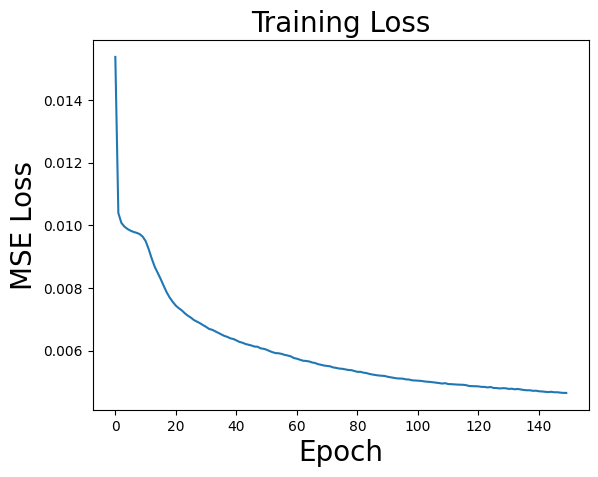

<Figure size 640x480 with 0 Axes>

In [67]:
# Plotting training loss
plt.figure()
plt.plot(loss_per_epoch[0:])
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE Loss', fontsize=20)
plt.title('Training Loss', fontsize=20)
plt.show()
plt.savefig(f'images/{save_name}/subject_{phantom_choice}/{dict_name}_{net_name}_{fp_prtcl_name}_loss.jpeg')
             

## 2.b. Glu maps (protocol 107a) ##

In [68]:
# Normalizing according to dict water_t1t2 min and max values
input_water_t1t2_acquired = torch.hstack((acquired_map_t1w, acquired_map_t2w))
input_water_t1t2_acquired = normalize_range(original_array=input_water_t1t2_acquired,
                                            original_min=min_water_t1t2_tensor,
                                            original_max=max_water_t1t2_tensor, new_min=0, new_max=1).to(device)

input_mt_param = normalize_range(original_array=input_mt_param,
                                            original_min=min_mt_param_tensor,
                                            original_max=max_mt_param_tensor, new_min=0, new_max=1).to(device)

# adding the water_t1t2 input as two additional elements in the noised_sig vector
acquired_data = torch.hstack((input_mt_param, input_water_t1t2_acquired, acquired_data_107)).to(device).float()


## 2.c. evaluate ##

In [69]:
reco_net.eval()
t0 = time.time()
prediction = reco_net(acquired_data.float())
print(f"Prediction took {time.time() - t0:.5f} seconds")

# Un-normalizing to go back to physical units
prediction = un_normalize_range(prediction, original_min=min_param_tensor.to(device),
                                original_max=max_param_tensor.to(device), new_min=0, new_max=1)

# print(prediction.shape)

# mask = np.ones((c_acq_data, w_acq_data))
quant_maps_glu = {}

# Reshaping back to the image dimension
quant_maps_glu['fs'] = prediction.cpu().detach().numpy()[:, 0]
quant_maps_glu['fs'] = quant_maps_glu['fs'].T
quant_maps_glu['fs'] = np.reshape(quant_maps_glu['fs'], (c_acq_data, w_acq_data), order='F')

quant_maps_glu['ksw'] = prediction.cpu().detach().numpy()[:, 1]
quant_maps_glu['ksw'] = quant_maps_glu['ksw'].T
quant_maps_glu['ksw'] = np.reshape(quant_maps_glu['ksw'], (c_acq_data, w_acq_data), order='F')


Prediction took 0.00200 seconds


## plot ##

In [70]:
full_mask = subject_dict['roi_mask']
date = subject_dict['month']
save_name = subject_dict['save_name']
temp = subject_dict['temp']


In [71]:
# Create custom Viridis colormap with black for 0 values
custom_viridis = np.array(plotly.colors.sequential.Viridis)
custom_viridis[0] = '#000000'  # Set black for 0 values

# Create custom Plasma colormap with black for 0 values
custom_plasma = np.array(plotly.colors.sequential.Plasma)
custom_plasma[0] = '#000000'  # Set black for 0 values

# Create subplots with 1 row and 3 columns, increased horizontal spacing
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.09, subplot_titles=['t1 [ms]', 't2 [ms]'])

# Add heatmaps for the three arrays
heatmap_fs = go.Heatmap(z=t1*mask, colorscale=custom_viridis, coloraxis='coloraxis1')
heatmap_ksw = go.Heatmap(z=t2*mask, colorscale=custom_plasma, coloraxis='coloraxis2')
# heatmap_fs = go.Heatmap(z=t1, colorscale=custom_viridis, coloraxis='coloraxis1')
# heatmap_ksw = go.Heatmap(z=t2, colorscale=custom_plasma, coloraxis='coloraxis2')

fig.add_trace(heatmap_fs, row=1, col=1)
fig.add_trace(heatmap_ksw, row=1, col=2)

fig.update_layout(
    template='plotly_dark',  # Set the theme to plotly dark
    title_text=f"Mouse {subject_i+1} {date} {temp}°C: t1 & t2 maps",
    showlegend=False,  # Hide legend
    height=345,
    width=900,  # Set a width based on your preference
    margin=dict(l=10, r=40, t=60, b=20),  # Adjust top and bottom margins
    title=dict(x=0.02, y=0.97)  # Adjust the title position
)

# Add individual titles and separate colorbars
for i, title in enumerate(['t1', 't2'], start=1):
    fig.update_xaxes(row=1, col=i, showgrid=False, showticklabels=False)
    fig.update_yaxes(showgrid=False, row=1, col=i, showticklabels=False, autorange='reversed')  # Reverse the y-axis

# Manually add separate colorbars
colorbar_fs = {'colorscale': custom_viridis, 'cmin': 1100, 'cmax': 2600}
colorbar_ksw = {'colorscale': custom_plasma, 'cmin': 30, 'cmax': 200}

fig.update_layout(
    coloraxis1=colorbar_fs,
    coloraxis2=colorbar_ksw,
    coloraxis_colorbar=dict(x=0.45, y=0.5),
    coloraxis2_colorbar=dict(x=1, y=0.5),
)

# Show the plot
fig.show()

pio.write_image(fig, f'images/{save_name}/subject_{phantom_choice}/t1_t2.jpeg')


In [72]:
import plotly.express as px
highres_data = bruker_dataset_highres.data
highres_data = dicom_data_arranger(bruker_dataset_highres, highres_fn).astype(np.float)

fig = px.imshow(highres_data[3, :,:])
fig.show()


In [73]:
# Create custom Viridis colormap with black for 0 values
custom_viridis = np.array(plotly.colors.sequential.Viridis)
custom_viridis[0] = '#000000'  # Set black for 0 values

# Create custom Plasma colormap with black for 0 values
custom_plasma = np.array(plotly.colors.sequential.Plasma)
custom_plasma[0] = '#000000'  # Set black for 0 values

# Create custom Viridis colormap with black for 0 values
custom_plotly3 = np.array(plotly.colors.sequential.Inferno)
custom_plotly3[0] = '#000000'  # Set black for 0 values

# Create custom Plasma colormap with black for 0 values
custom_aggrnyl = np.array(plotly.colors.sequential.Electric)
custom_aggrnyl[0] = '#000000'  # Set black for 0 values

# Create custom Viridis colormap with black for 0 values
custom_magma = np.array(plotly.colors.sequential.Magma)
custom_magma[0] = '#000000'  # Set black for 0 values

# Create custom Plasma colormap with black for 0 values
custom_cividis = np.array(plotly.colors.sequential.Cividis)
custom_cividis[0] = '#000000'  # Set black for 0 values

# Create subplots with 1 row and 3 columns, increased horizontal spacing
fig = make_subplots(rows=1, cols=4, horizontal_spacing=0.06, subplot_titles=['t1 [ms]', 't2 [ms]', 'MT (%)', 'MT ksw [Hz]', 'Glu [mM]', 'Glu ksw [Hz]'])

# Add heatmaps for the three arrays
heatmap_t1 = go.Heatmap(z=t1*full_mask, colorscale=custom_viridis, coloraxis='coloraxis1')
heatmap_t2 = go.Heatmap(z=t2*full_mask, colorscale=custom_plasma, coloraxis='coloraxis2')
heatmap_fs = go.Heatmap(z=quant_maps_mt['fs']*100*full_mask, colorscale=custom_viridis, coloraxis='coloraxis3')
heatmap_ksw = go.Heatmap(z=quant_maps_mt['ksw']*full_mask, colorscale=custom_plasma, coloraxis='coloraxis4')

fig.add_trace(heatmap_t1, row=1, col=1)
fig.add_trace(heatmap_t2, row=1, col=2)
fig.add_trace(heatmap_fs, row=1, col=3)
fig.add_trace(heatmap_ksw, row=1, col=4)

fig.update_layout(
    template='plotly_dark',  # Set the theme to plotly dark
    title_text=f"Mouse {subject_i+1} {date} {temp}°C: '52MT' NN",
    showlegend=False,  # Hide legend
    height=300,
    width=1400,  # Set a width based on your preference
    margin=dict(l=10, r=100, t=60, b=20),  # Adjust top and bottom margins
    title=dict(x=0.02, y=0.97)  # Adjust the title position
)

# Add individual titles and separate colorbars
for i, title in enumerate([1, 2 ,3, 4], start=1):
    fig.update_xaxes(row=1, col=i, showgrid=False, showticklabels=False)
    fig.update_yaxes(showgrid=False, row=1, col=i, showticklabels=False, autorange='reversed')  # Reverse the y-axis

# Manually add separate colorbars
f_const = 3 / 110000
colorbar_t1 = {'colorscale': custom_plotly3} #, 'cmin': 0, 'cmax': f_lims[1]/f_const}
colorbar_t2 = {'colorscale': custom_aggrnyl} #, 'cmin': k_lims[0], 'cmax': k_lims[1]}
colorbar_fs = {'colorscale': custom_viridis} #, 'cmin': 0, 'cmax': f_lims[1]/f_const}
colorbar_ksw = {'colorscale': custom_plasma} #, 'cmin': k_lims[0], 'cmax': k_lims[1]}

fig.update_layout(
    coloraxis1=colorbar_t1,
    coloraxis2=colorbar_t2,
    coloraxis3=colorbar_fs,
    coloraxis4=colorbar_ksw,
    coloraxis_colorbar=dict(x=0.205, y=0.5),
    coloraxis2_colorbar=dict(x=0.47, y=0.5),
    coloraxis3_colorbar=dict(x=0.735, y=0.5),
    coloraxis4_colorbar=dict(x=1, y=0.5),
)

# Show the plot
fig.show()

pio.write_image(fig, f'images/{save_name}/subject_{phantom_choice}/{fp_prtcl_name}_mt_sequential.jpeg')


In [74]:
# Create subplots with 1 row and 3 columns, increased horizontal spacing
fig = make_subplots(rows=3, cols=2, horizontal_spacing=0.1, vertical_spacing=0.03, 
                    subplot_titles=['t1 [ms]', 't2 [ms]', 'MT (%)', 'MT ksw [Hz]', 'Glu [mM]', 'Glu ksw [Hz]'])

# Add heatmaps for the three arrays
heatmap_t1 = go.Heatmap(z=t1*full_mask, colorscale=custom_viridis, coloraxis='coloraxis1')
heatmap_t2 = go.Heatmap(z=t2*full_mask, colorscale=custom_plasma, coloraxis='coloraxis2')
heatmap_mt_fs = go.Heatmap(z=quant_maps_mt['fs']*100*full_mask, colorscale=custom_viridis, coloraxis='coloraxis3')
heatmap_mt_ksw = go.Heatmap(z=quant_maps_mt['ksw']*full_mask, colorscale=custom_plasma, coloraxis='coloraxis4')
heatmap_fs = go.Heatmap(z=quant_maps_glu['fs']*(110000/3)*full_mask, colorscale=custom_viridis, coloraxis='coloraxis5')
heatmap_ksw = go.Heatmap(z=quant_maps_glu['ksw']*full_mask, colorscale=custom_plasma, coloraxis='coloraxis6')

fig.add_trace(heatmap_t1, row=1, col=1)
fig.add_trace(heatmap_t2, row=1, col=2)
fig.add_trace(heatmap_mt_fs, row=2, col=1)
fig.add_trace(heatmap_mt_ksw, row=2, col=2)
fig.add_trace(heatmap_fs, row=3, col=1)
fig.add_trace(heatmap_ksw, row=3, col=2)

fig.update_layout(
    template='plotly_dark',  # Set the theme to plotly dark
    title_text=f"Mouse {subject_i+1} {date} {temp}°C: '{fp_prtcl_name}' Glutamate MRF Sequential NN (noise 0.{glu_noise})",
    showlegend=False,  # Hide legend
    height=900,
    width=900,  # Set a width based on your preference
    margin=dict(l=10, r=40, t=80, b=20),  # Adjust top and bottom margins
    title=dict(x=0.02, y=0.97)  # Adjust the title position
)

# Add individual titles and separate colorbars
for i, title in enumerate([1, 2, 3], start=1):
    fig.update_xaxes(row=i, col=1, showgrid=False, showticklabels=False)
    fig.update_xaxes(row=i, col=2, showgrid=False, showticklabels=False)
    fig.update_yaxes(showgrid=False, row=i, col=1, showticklabels=False, autorange='reversed')  # Reverse the y-axis
    fig.update_yaxes(showgrid=False, row=i, col=2, showticklabels=False, autorange='reversed')  # Reverse the y-axis

# Manually add separate colorbars
f_const = 3 / 110000
colorbar_t1 = {'colorscale': custom_plotly3} #, 'cmin': 0, 'cmax': f_lims[1]/f_const}
colorbar_t2 = {'colorscale': custom_aggrnyl} #, 'cmin': k_lims[0], 'cmax': k_lims[1]}
colorbar_mt_fs = {'colorscale': custom_viridis}
colorbar_mt_ksw = {'colorscale': custom_plasma}
colorbar_fs = {'colorscale': custom_magma}
colorbar_ksw = {'colorscale': custom_cividis}


fig.update_layout(
    coloraxis1=colorbar_t1,
    coloraxis2=colorbar_t2,
    coloraxis3=colorbar_mt_fs,
    coloraxis4=colorbar_mt_ksw,
    coloraxis5=colorbar_fs,
    coloraxis6=colorbar_ksw,
    coloraxis_colorbar=dict(x=0.45, y=0.85, len=0.3),
    coloraxis2_colorbar=dict(x=1, y=0.85, len=0.3),
    coloraxis3_colorbar=dict(x=0.45, y=0.5, len=0.3),
    coloraxis4_colorbar=dict(x=1, y=0.5, len=0.3),
    coloraxis5_colorbar=dict(x=0.45, y=0.15, len=0.3),
    coloraxis6_colorbar=dict(x=1, y=0.15, len=0.3),
)

# Show the plot
fig.show()

pio.write_image(fig, f'images/{save_name}/subject_{phantom_choice}/{dict_name}_{net_name}_{fp_prtcl_name}_glu_sequential.jpeg')


In [75]:
# Create subplots with 1 row and 3 columns, increased horizontal spacing
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.1, vertical_spacing=0.03, 
                    subplot_titles=['Glu [mM]', 'Glu ksw [Hz]'])

# Add heatmaps for the three arrays
heatmap_fs = go.Heatmap(z=quant_maps_glu['fs']*(110000/3)*full_mask, colorscale=custom_viridis, coloraxis='coloraxis5')
heatmap_ksw = go.Heatmap(z=quant_maps_glu['ksw']*full_mask, colorscale=custom_plasma, coloraxis='coloraxis6')

fig.add_trace(heatmap_fs, row=1, col=1)
fig.add_trace(heatmap_ksw, row=1, col=2)

fig.update_layout(
    template='plotly_dark',  # Set the theme to plotly dark
    title_text=f"Mouse {subject_i+1} {date} {temp}°C: '{fp_prtcl_name}' Glutamate MRF Sequential NN (noise 0.{glu_noise})",
    showlegend=False,  # Hide legend
    height=350,
    width=900,  # Set a width based on your preference
    margin=dict(l=10, r=40, t=80, b=20),  # Adjust top and bottom margins
    title=dict(x=0.02, y=0.97)  # Adjust the title position
)

# Add individual titles and separate colorbars
for i, title in enumerate([1, 2, 3], start=1):
    fig.update_xaxes(row=i, col=1, showgrid=False, showticklabels=False)
    fig.update_xaxes(row=i, col=2, showgrid=False, showticklabels=False)
    fig.update_yaxes(showgrid=False, row=i, col=1, showticklabels=False, autorange='reversed')  # Reverse the y-axis
    fig.update_yaxes(showgrid=False, row=i, col=2, showticklabels=False, autorange='reversed')  # Reverse the y-axis

# Manually add separate colorbars
f_const = 3 / 110000
colorbar_fs = {'colorscale': custom_magma}
colorbar_ksw = {'colorscale': custom_cividis}


fig.update_layout(
    coloraxis1=colorbar_fs,
    coloraxis2=colorbar_ksw,
    coloraxis_colorbar=dict(x=0.45, y=0.15, len=0.3),
    coloraxis2_colorbar=dict(x=1, y=0.15, len=0.3),
)

# Show the plot
fig.show()

pio.write_image(fig, f'images/{save_name}/subject_{phantom_choice}/{dict_name}_{net_name}_{fp_prtcl_name}_glu_sequential_kf.jpeg')
